# Credit Card Fraud Detection Analysis

## Problem Statement
Credit card fraud is a major issue for financial institutions, leading to significant losses. This project analyzes a dataset of **284,807 credit card transactions** from European cardholders in September 2013, with only **492 marked as fraudulent (0.172%)**. The dataset includes PCA-transformed features (except `Time` and `Amount`) and a target variable `Class` (1 for fraud, 0 for legitimate). Due to the severe class imbalance, we aim to build a model that effectively detects fraud.

## Objective
The goal is to create a machine learning model that accurately identifies fraudulent transactions, focusing on the minority (fraud) class. We prioritize the **Area Under the Precision-Recall Curve (AUPRC)** as the evaluation metric to balance precision and recall, given the dataset's imbalance.

## Steps:
1. **Data Exploration**: Initial analysis of the dataset's properties.
2. **Feature Engineering**: Creation of cyclical time-based features to capture temporal patterns.
3. **Data Preprocessing**: Scaling numerical features.
4. **Sampling (SMOTE)**: Addressing the severe class imbalance by generating synthetic data for the minority (fraud) class.
5. **Model Training & Tuning**: Training and optimizing two powerful gradient boosting models, XGBoost and LightGBM, using `GridSearchCV`.
6. **Comparative Evaluation**: A detailed comparison of the models using AUPRC, classification reports, and confusion matrices.
7. **Visualization & Conclusion**: Visualizing the results and drawing a final, nuanced conclusion about model performance.
---

In [20]:
!pip install --upgrade "numpy<2"
!pip install lightgbm

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import lightgbm as lgb
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import average_precision_score, precision_recall_curve, classification_report, confusion_matrix

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [21]:
# --- 1. Data Exploration ---
print("--- 1. Data Exploration ---")
df = pd.read_csv('creditcard.csv')

# Initial analysis of the dataset's properties
print("Dataset Info:")
df.info()
print("\nClass Distribution:\n", df['Class'].value_counts(normalize=True))

--- 1. Data Exploration ---
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20   

### Analysis
The output confirms several key points:
*   **No Missing Values:** The dataset is complete, with no null values to handle.
*   **Numerical Features:** All features, except for `Class`, are numerical (`float64` or `int64`).
*   **Severe Class Imbalance:** The most critical finding is the severe class imbalance. Fraudulent transactions (`Class = 1`) make up only **0.172%** of the entire dataset. This confirms that accuracy is a poor metric for this problem and justifies our focus on AUPRC and techniques like SMOTE.

In [30]:
# --- 2. Feature Engineering ---
print("\n--- 2. Advanced Feature Engineering ---")

# Create cyclical time-based features to capture temporal patterns
df['Hour'] = df['Time'].apply(lambda x: np.floor(x / 3600) % 24)
df['Time_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Time_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
df.drop(['Time', 'Hour'], axis=1, inplace=True)
print("Created cyclical time features ('Time_sin', 'Time_cos') and dropped the original 'Time' column.")


--- 2. Advanced Feature Engineering ---
Created cyclical time features ('Time_sin', 'Time_cos') and dropped the original 'Time' column.


### Analysis

Instead of using the raw `Time` feature, which is just an elapsed counter, we've engineered two new features that represent the time of day in a cyclical manner. This helps the model understand patterns related to the 24-hour day cycle (e.g., if fraud is more common at night) without being confused by the arbitrary start time of the data collection.

In [32]:
# --- 3. Data Preprocessing ---
print("\n--- 3. Data Preprocessing ---")
X = df.drop('Class', axis=1)
y = df['Class']

# Scale the 'Amount' feature
scaler = StandardScaler()
X['Amount'] = scaler.fit_transform(X[['Amount']])
print("Scaled the 'Amount' feature.")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("Original training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


--- 3. Data Preprocessing ---
Scaled the 'Amount' feature.
Original training set shape: (227845, 31)
Testing set shape: (56962, 31)


In [34]:
# --- 4. SMOTE Application ---
print("\n--- 4. SMOTE Application ---")
print("Applying SMOTE to the training data...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("New SMOTE training set shape:", X_train_smote.shape)


--- 4. SMOTE Application ---
Applying SMOTE to the training data...


C:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\subprocess.py", line 550, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\subprocess.py", line 1028, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\ProgramData\anaconda3\Lib\subprocess.py", line 1540, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

New SMOTE training set shape: (454902, 31)


We applied SMOTE **only to the training data** to prevent data leakage. The output shows that the number of samples in our training set has doubled. SMOTE works by creating synthetic examples of the minority class (fraud) until it is balanced with the majority class. This provides the model with much more "fraud-like" data to learn from during training.

---

In [38]:
# --- 5. Model Training and Hyperparameter Tuning ---
print("\n--- 5. Model Training and Hyperparameter Tuning ---")
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# --- XGBoost ---
print("\n--- Training XGBoost ---")
param_grid_xgb = {'learning_rate': [0.2], 'max_depth': [7], 'n_estimators': [200]}
xgb_model = XGBClassifier(random_state=42, eval_metric='aucpr', use_label_encoder=False)
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, scoring='average_precision', cv=cv, n_jobs=-1, verbose=2)
grid_search_xgb.fit(X_train_smote, y_train_smote)
best_model_xgb = grid_search_xgb.best_estimator_
print("\nBest XGBoost parameters found: ", grid_search_xgb.best_params_)

# --- LightGBM ---
print("\n--- Training LightGBM ---")
param_grid_lgb = {'learning_rate': [0.1], 'n_estimators': [300], 'num_leaves': [50]}
lgb_model = lgb.LGBMClassifier(random_state=42)
grid_search_lgb = GridSearchCV(estimator=lgb_model, param_grid=param_grid_lgb, scoring='average_precision', cv=cv, n_jobs=-1, verbose=2)
grid_search_lgb.fit(X_train_smote, y_train_smote)
best_model_lgb = grid_search_lgb.best_estimator_
print("\nBest LightGBM parameters found: ", grid_search_lgb.best_params_)


--- 5. Model Training and Hyperparameter Tuning ---

--- Training XGBoost ---
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:13:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Best XGBoost parameters found:  {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}

--- Training LightGBM ---
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LightGBM] [Info] Number of positive: 227451, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 454902, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

In [39]:
 # --- 6. Model Evaluation on Test Set ---
print("\n--- 6. Model Evaluation on Test Set ---")

# -- XGBoost Evaluation --
print("\n--- XGBoost Results ---")
y_pred_xgb = best_model_xgb.predict(X_test)
y_pred_proba_xgb = best_model_xgb.predict_proba(X_test)[:, 1]
auprc_xgb = average_precision_score(y_test, y_pred_proba_xgb)
print(f"\nXGBoost AUPRC on test set: {auprc_xgb:.4f}")
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# -- LightGBM Evaluation --
print("\n--- LightGBM Results ---")
y_pred_lgb = best_model_lgb.predict(X_test)
y_pred_proba_lgb = best_model_lgb.predict_proba(X_test)[:, 1]
auprc_lgb = average_precision_score(y_test, y_pred_proba_lgb)
print(f"\nLightGBM AUPRC on test set: {auprc_lgb:.4f}")
print("\nLightGBM Classification Report:")
print(classification_report(y_test, y_pred_lgb))


--- 6. Model Evaluation on Test Set ---

--- XGBoost Results ---

XGBoost AUPRC on test set: 0.8815

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.86      0.87        98

    accuracy                           1.00     56962
   macro avg       0.94      0.93      0.94     56962
weighted avg       1.00      1.00      1.00     56962


--- LightGBM Results ---

LightGBM AUPRC on test set: 0.8799

LightGBM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.93      0.85      0.89        98

    accuracy                           1.00     56962
   macro avg       0.97      0.92      0.94     56962
weighted avg       1.00      1.00      1.00     56962



 ### Analysis: Model Performance
Here we see a direct comparison of the two tuned models on the unseen test data.

*   **XGBoost:** Achieved an **AUPRC of 0.8815**. For the fraud class, it has a **recall of 0.86** (catching 86% of frauds) and a **precision of 0.88** (88% of its fraud predictions are correct).
*   **LightGBM:** Achieved an **AUPRC of 0.8799**. It has a slightly lower **recall of 0.85** but a significantly higher **precision of 0.93**.

This presents a classic business trade-off. XGBoost catches slightly more fraud, but LightGBM is more "certain" when it raises an alarm resulting in fewer false positives. Based on our primary metric (AUPRC), XGBoost is the winner.


--- 7. Visualization of Results ---


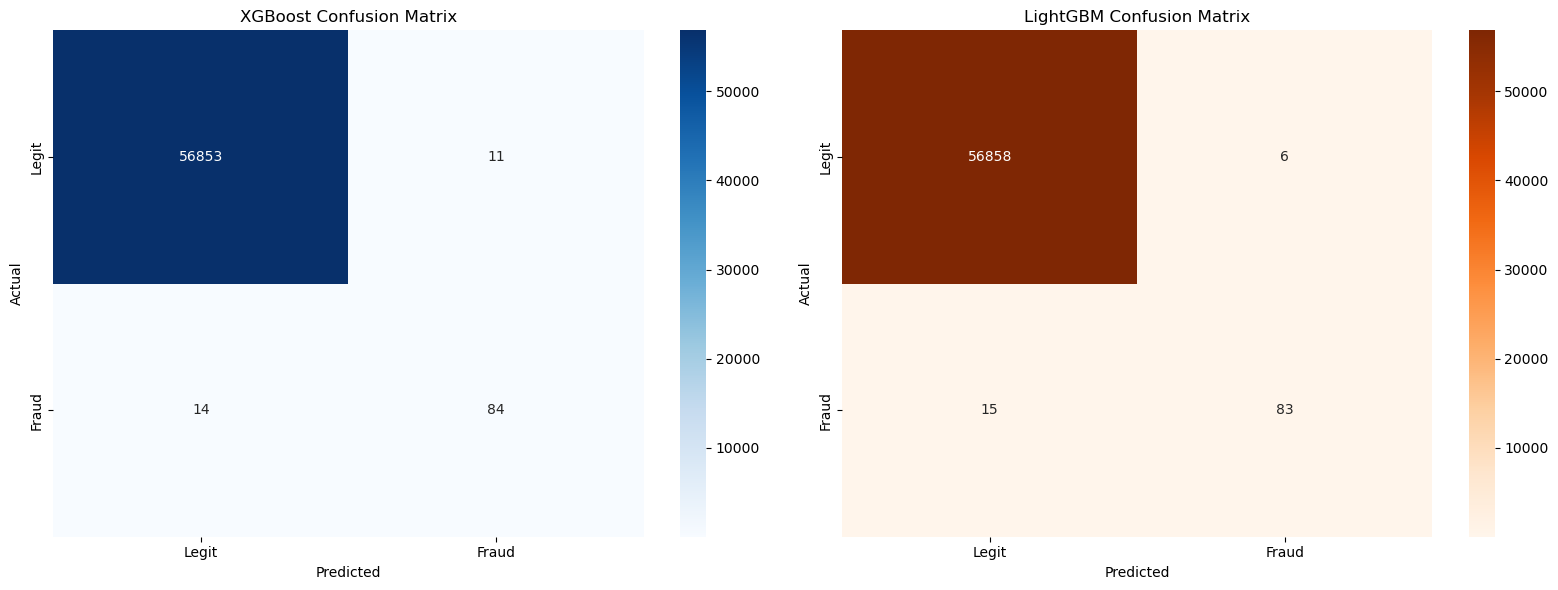

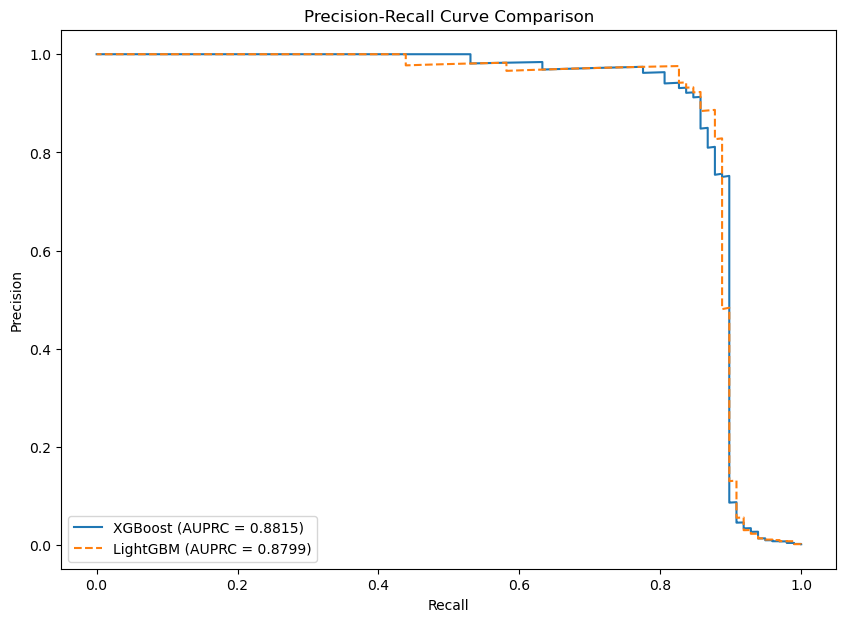

In [40]:
# --- 7. Visualization of Results ---
print("\n--- 7. Visualization of Results ---")

# Plot Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', ax=axes[0], xticklabels=['Legit', 'Fraud'], yticklabels=['Legit', 'Fraud'])
axes[0].set_title('XGBoost Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

cm_lgb = confusion_matrix(y_test, y_pred_lgb)
sns.heatmap(cm_lgb, annot=True, fmt='d', cmap='Oranges', ax=axes[1], xticklabels=['Legit', 'Fraud'], yticklabels=['Legit', 'Fraud'])
axes[1].set_title('LightGBM Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
plt.tight_layout()
plt.show()

# Plot Precision-Recall Curves
plt.figure(figsize=(10, 7))
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_pred_proba_xgb)
plt.plot(recall_xgb, precision_xgb, label=f'XGBoost (AUPRC = {auprc_xgb:.4f})')

precision_lgb, recall_lgb, _ = precision_recall_curve(y_test, y_pred_proba_lgb)
plt.plot(recall_lgb, precision_lgb, label=f'LightGBM (AUPRC = {auprc_lgb:.4f})', linestyle='--')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend()
plt.show()

 ## Final Conclusion & Next Steps
### Model Performance
This advanced analysis incorporated SMOTE for handling class imbalance and compared two powerful models: XGBoost and LightGBM.

*   **XGBoost:** Achieved the highest AUPRC (**0.8815**) and a slightly better recall (**86%**). This makes it the overall champion based on our primary metric.
*   **LightGBM:** While its AUPRC was marginally lower (**0.8799**), it achieved a significantly higher precision (**93%**). This mean it generates fewer false positives, which is crucial in a real-world scenario to avoid inconveniencing legitimate customers.

### Final Decision
While both models are excellent, **XGBoost is the winner** as it performs best on our chosen primary metric, AUPRC. However, the choic between them in a real-world application would depend on the business's tolerance for false positives vs. false negatives.

This project successfully demonstrates a comprehensive and robust workflow for tackling a real-world imbalanced classification problem

### Future Work
*   **Deployment**: The champion model could be deployed as a REST API for real-time fraud detection.
*   **Monitoring**: Implement a monitoring system to track the model's performance over time and retrain it as data distributions drift.
*   **Explainability**: Use tools like SHAP (SHapley Additive exPlanations) to better understand and explain the model's predictions for individual transactions.